# Coursework 2: Image Classification

In this coursework, you are going to develop a neural network model for for image classification.

## What to do?

* Complete and run the code using `jupyter-lab` or `jupyter-notebook` to get the results.

* Export (File | Export Notebook As...) or print (using the print function of your browser) the notebook as a pdf file, which contains your code, results and text answers, and upload the pdf file onto [Cate](https://cate.doc.ic.ac.uk).

## Dependencies:

If you do not have Jupyter-Lab on your laptop, you can find information for installing Jupyter-Lab [here](https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html).

There may be certain Python packages you may want to use for completing the coursework. We have provided examples below for importing libraries. If some packages are missing, you need to install them. In general, new packages (e.g. imageio etc) can be installed by running 

`pip3 install [package_name]`

in the terminal. If you use Anaconda, you can also install new packages by running `conda install [package_name]` or using its graphic user interface.

In [1]:
# Import libraries (provided)
import numpy as np 
import matplotlib.pyplot as plt
import time
import random
from sklearn import metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torchsummary import summary

## 1. Load and visualise data. (25 marks)

Throughout this coursework. you will be working with the Fashion-MNIST dataset. If you are interested, you may find information about the dataset in this paper.

[1] Han Xiao, Kashif Rasul, Roland Vollgraf. Fashion-MNIST: A novel image dataset for benchmarking machine learning algorithms. [arXiv:1708.07747](https://arxiv.org/abs/1708.07747)

The dataset is prepared in a similar way to MNIST. It is split into a training set of 60,000 images and a test set of 10,000 images. The images are of size 28x28 pixels.

There are in total 10 label classes, which are:

| Label       | Description |
| ----------- | ----------- |
| 0  |  T-shirt/top |
| 1  |  Trousers    |
| 2  |  Pullover    |
| 3  |  Dress       |
| 4  |  Coat        |
| 5  |  Sandal      |
| 6  |  Shirt       |
| 7  |  Sneaker     |
| 8  |  Bag         |
| 9  |  Ankle boot  |

In [2]:
# Load data (provided)
# Note that some early versions of torchvision use different names, such as train_data, test_data instead of data.
# However, after torchvision version 0.4.0, data is used as the variable name.
train_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=True)
train_image = np.array(train_set.data)
train_label = np.array(train_set.targets)
class_name = train_set.classes

test_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=False)
test_image = np.array(test_set.data)
test_label = np.array(test_set.targets)


### 1.1 Display the dimension of the training and test sets. (5 marks)

In [3]:
print("Dimension of the training set: ",train_image.shape,", training label: ",train_label.shape)
print("Dimension of the test set: ",test_image.shape,", test label: ",test_label.shape)

Dimension of the training set:  (60000, 28, 28) , training label:  (60000,)
Dimension of the test set:  (10000, 28, 28) , test label:  (10000,)


### 1.2 Visualise sample images for each of the 10 classes. (5 marks)

Please plot 10 rows x 10 columns of images. Each row shows 10 samples for one class. For example, row 1 shows 10 `T-shirt/top` images, row 2 shows 10 `Trousers` images.

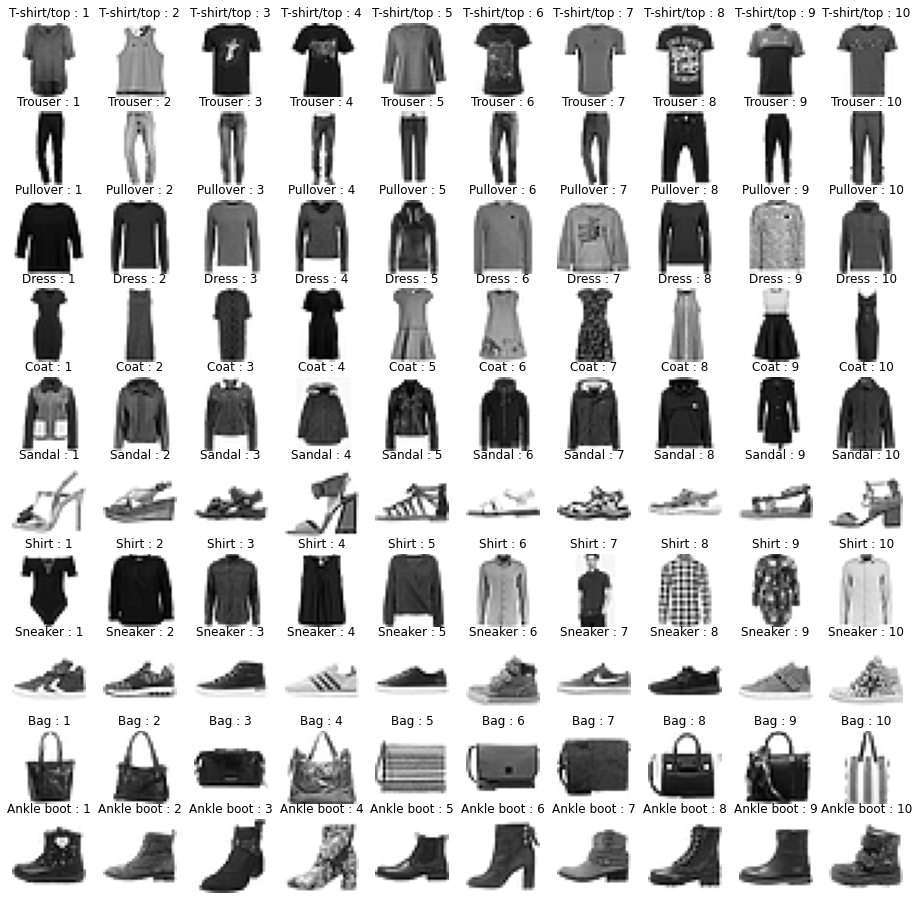

In [4]:
classes = list(set(train_label))
#get indices for each class
indices = {v: np.where(train_label == v)[0].tolist() for v in np.unique(train_label)}
rng = np.random.default_rng()
img_idx = []
for label in classes:
    # all indices for this class label
    all_idx = np.array(indices[label])
    # randomly select 10 pictures in this class
    ten_img = rng.integers(low=0, high=len(all_idx), size=10)
    # save the 10 indices in an output matrix
    img_idx.append(all_idx[ten_img])

rows,cols = 10,10
axes=[]
fig=plt.figure()
fig.set_size_inches(16, 16)
i = 0

for j,label in enumerate(img_idx):
    for k,idx in enumerate(label):
        axes.append( fig.add_subplot(rows, cols, i+1) )
        subplot_title=(class_name[j]+ " : " + str(k+1))
        axes[-1].set_title(subplot_title)
        axes[-1].axis('off')
        plt.imshow(train_image[idx],cmap=plt.cm.binary)
        i+=1

plt.show()

### 1.3 Display the number of training samples for each class. (5 marks)

In [5]:
for label in classes:
    # indices for this class label
    idx = indices[label]
    print("Number of traning samples for ", class_name[label], ": ", len(idx))

Number of traning samples for  T-shirt/top :  6000
Number of traning samples for  Trouser :  6000
Number of traning samples for  Pullover :  6000
Number of traning samples for  Dress :  6000
Number of traning samples for  Coat :  6000
Number of traning samples for  Sandal :  6000
Number of traning samples for  Shirt :  6000
Number of traning samples for  Sneaker :  6000
Number of traning samples for  Bag :  6000
Number of traning samples for  Ankle boot :  6000


### 1.4 Discussion. (10 marks)

Is the dataset balanced? Would you prefer a balanced or unbalanced dataset? Explain why?

Yes the dataset is perfectly balanced.
A balanced dataset is generally always preferred (except anomaly detection) because there is no bias in the learning examples and the model can learn from all classes.

Models trained on an imbalanced dataset will be quite good at predicting the majority classes but will be terrible at 
classifying the minority classes. Many machine learning models and performance metrics are based on the assumption 
that the dataset come from a balanced distribution, and imbalanced datasets will violate this assuption, making intepretation of macro-average performance tricky (e.g. 95$\%$ accuracy, with 100$\%$ recall for the positive class, on an imbalanced dataset with only 5$\%$ negative instances). Class-wise performance evaluation is necessary in such case to see the full picture.

## 2. Image classification. (55 marks)

### 2.1 Build a convolutional neural network using the `PyTorch` library to perform classification on the Fashion-MNIST dataset. (15 marks)

You can design a network architecture similar to LeNet (shown below), which consists a number of convolutional layers and a few fully connected layers at the end.

![](lenet.png)

In [112]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn = nn.Sequential(
            # First Layer C1: (N, 1, 28, 28) -> (N, 6, 24, 24) Feature maps
            nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, stride = 1, padding = 0),
            nn.Tanh(),
            # Second Layer S2: (N, 6, 24, 24) -> (N, 6, 12, 12) Downsampling
            nn.AvgPool2d(kernel_size = 2, stride = 2),
            # Third Layer C3: (N, 6, 12, 12) -> (N, 16, 8, 8) Feature maps 
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 0),
            nn.Tanh(),
            # Fourth Layer S4: (N, 16, 8, 8) -> (N, 16, 4, 4) Downsampling 
            nn.AvgPool2d(kernel_size = 2, stride = 2),
        )
    
        # from convolution layers to fully connected layers
        self.full = nn.Sequential(
            # Fifth Layer C5: 4 x 4 x 16 =256
            nn.Linear(256, 120),
            nn.Tanh(),
            # Sixth Layer F6
            nn.Linear(120, 84),
            nn.Tanh(),
            # Sixth Layer F6: generate proability for 10 classes
            nn.Linear(84, 10),
            # use softmax for multiclassification to push the highest probability up and all classes sum to 1
            nn.Softmax(dim=1),
        )

    def forward(self, x):
    
        y_hat = self.cnn(x)
        # Flatten the 3D feature maps to 1D before going through regressions
        y_hat = y_hat.reshape(y_hat.shape[0], -1)
        y_hat = self.full(y_hat) 
    
        return y_hat

    def predict(self, x):
        y_hat = self.forward(x)
        y_hat = list(y_hat.detach().numpy())
        # the maximum probability class as prediction
        y_hat = np.argmax(y_hat, axis=1)
        
        return y_hat
        
        
# Since most of you use laptops, you may use CPU for training.
# If you have a good GPU, you can set this to 'gpu'.
device = 'cpu'

# Network
model = Net().to(device)
print(model)

summary(model, (1,28,28), 64)

Net(
  (cnn): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (full): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [64, 6, 24, 24]             156
              Tanh-2            [64, 6, 24, 24]               0
         AvgPool2d-3            [64, 6, 12, 12]               0
            Conv2d-4             [64, 16, 8, 8]           2,416
              Tanh-5             [64, 16, 8, 8]              

### 2.2 Define the loss function, optimiser and hyper-parameters such as the learning rate, number of iterations, batch size etc. (5 marks)

In [120]:
# loss function
criterion = nn.CrossEntropyLoss()

model = Net()
# Adam Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# number of iterations
epoch = 10

# batch size
batch_size = 64

# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

### 2.3 Start model training. (15 marks)

At each iteration, get a random batch of images and labels from train_image and train_label, convert them into torch tensors, feed into the network model and perform gradient descent.

Print out training loss and training time.

Final epoch Loss : 1.5826546530077272
Average Loss per epoch:  1.6088765910748102


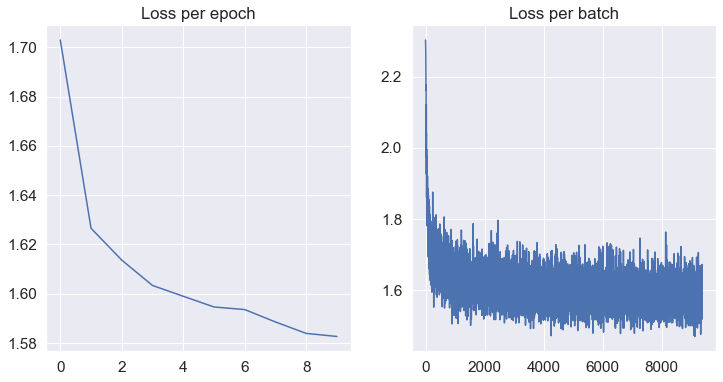

Training time: 54.30726495500039 s
Training Accuracy:  0.8873833333333333
[[5302    5  105  154   26   10  330    0   68    0]
 [   6 5871   10   81   10    0   18    0    4    0]
 [  80    9 4983   73  633    0  195    0   27    0]
 [ 153   52   32 5474  196    1   81    0   11    0]
 [   6    6  403  227 5048    0  290    0   20    0]
 [   1    0    2    0    1 5690    0  251   12   43]
 [1003   12  757  188  561    0 3421    0   58    0]
 [   0    0    0    0    0   16    0 5840   11  133]
 [  16    3   48   21   28    6   37    6 5831    4]
 [   0    0    0    0    1   29    0  184    3 5783]]


In [121]:
from statistics import mean
#random seed for shuffling
seed = 330

def train(model, x, y,  batch_size, optimizer, epoch):
    n_batches = int(len(x) / batch_size)
    # save losses to plot figures
    losses_batch = []
    losses_epoch = []
    rng = np.random.default_rng(seed)
    
    for epoch in range(epoch):
        # Shuffling data for each epoch
        shuffled_X = rng.permutation(x.shape[0])
        for batch in range(n_batches):
            batch_X = x[shuffled_X[batch*batch_size:(batch+1)*batch_size,]]
            batch_y = y[shuffled_X[batch*batch_size:(batch+1)*batch_size,]]
            
            y_hat = model(batch_X)
            loss = criterion(y_hat, batch_y)
            
            # zero the gradient buffers
            optimizer.zero_grad()  
            
            # get the gradients
            loss.backward()
            
            # save loss to draw graph
            losses_batch.append(loss.item())
            
            #gradient clipping: didn't seem to make a big difference
            torch.nn.utils.clip_grad_norm_(model.parameters(),1)
            
            # Update parameters
            optimizer.step()    
            
        avg_loss = mean(losses_batch[-n_batches:])
        losses_epoch.append(avg_loss)
        
    last_epoch_loss = losses_epoch[-1]
    avg_loss = mean(losses_epoch)
    print('Final epoch Loss :', last_epoch_loss)
    print('Average Loss per epoch: ', avg_loss)
    
    # Figures on Loss during learning
    axes=[]
    fig=plt.figure(figsize = (12,6))
    
    axes.append(fig.add_subplot(1, 2, 1) )
    subplot_title=("Loss per epoch")
    axes[-1].set_title(subplot_title)
    plt.plot(losses_epoch, label='Training loss')

    axes.append(fig.add_subplot(1, 2, 2) )
    subplot_title=("Loss per batch")
    axes[-1].set_title(subplot_title)
    plt.plot(losses_batch, label='Training loss')
    plt.show()
    
    return


# convert data into torch tensors
x_train = np.expand_dims(train_image, axis=1)
x_tensor = torch.from_numpy(x_train).float()

# training
start = time.perf_counter()
train(model, x_tensor, train_set.targets,  batch_size, optimizer, epoch)
elapsed = (time.perf_counter() - start)
print("Training time:", elapsed, "s")

#show performance on training set
predictions = model.predict(x_tensor)
print("Training Accuracy: ", metrics.accuracy_score(train_label, predictions))
print(metrics.confusion_matrix(train_label, predictions))

### 2.4 Deploy the trained model onto the test set. (10 marks)

Please also evaluate how long it takes for testing.

In [122]:
# Convert test data into torch tensors
x_test = np.expand_dims(test_image, axis=1)
x_tensor = torch.from_numpy(x_test).float()

# get predictions using trained model
start = time.perf_counter()
predictions = model.predict(x_tensor)
elapsed = (time.perf_counter() - start)
print("Testing time:", elapsed, "s")

Testing time: 0.37655553900003724 s


### 2.5 Evaluate the classification accuracy on the test set. (5 marks)

In [123]:
print('Accuracy on the test set: ',metrics.accuracy_score(test_label, predictions))
print(metrics.classification_report(test_label, predictions, target_names=class_name))

Accuracy on the test set:  0.8772
              precision    recall  f1-score   support

 T-shirt/top       0.81      0.88      0.84      1000
     Trouser       0.98      0.97      0.98      1000
    Pullover       0.77      0.81      0.79      1000
       Dress       0.86      0.90      0.88      1000
        Coat       0.76      0.83      0.79      1000
      Sandal       0.99      0.94      0.96      1000
       Shirt       0.77      0.55      0.64      1000
     Sneaker       0.91      0.98      0.94      1000
         Bag       0.95      0.97      0.96      1000
  Ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.87     10000
weighted avg       0.88      0.88      0.87     10000



### 2.6 Print out and visualise the confusion matrix. (5 marks)
You can use relevant functions in [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

[[877   4  17  29   6   0  52   0  15   0]
 [  0 972   3  16   3   1   3   0   2   0]
 [ 17   1 809  15 115   0  40   0   3   0]
 [ 26   6   7 900  34   0  23   0   4   0]
 [  0   2  80  40 829   0  46   0   3   0]
 [  0   0   0   1   0 944   0  43   0  12]
 [164   2 122  37 106   0 549   0  20   0]
 [  0   0   0   0   0   4   0 976   0  20]
 [  2   1  10   8   4   1   2   4 968   0]
 [  0   0   1   0   0   7   0  44   0 948]]


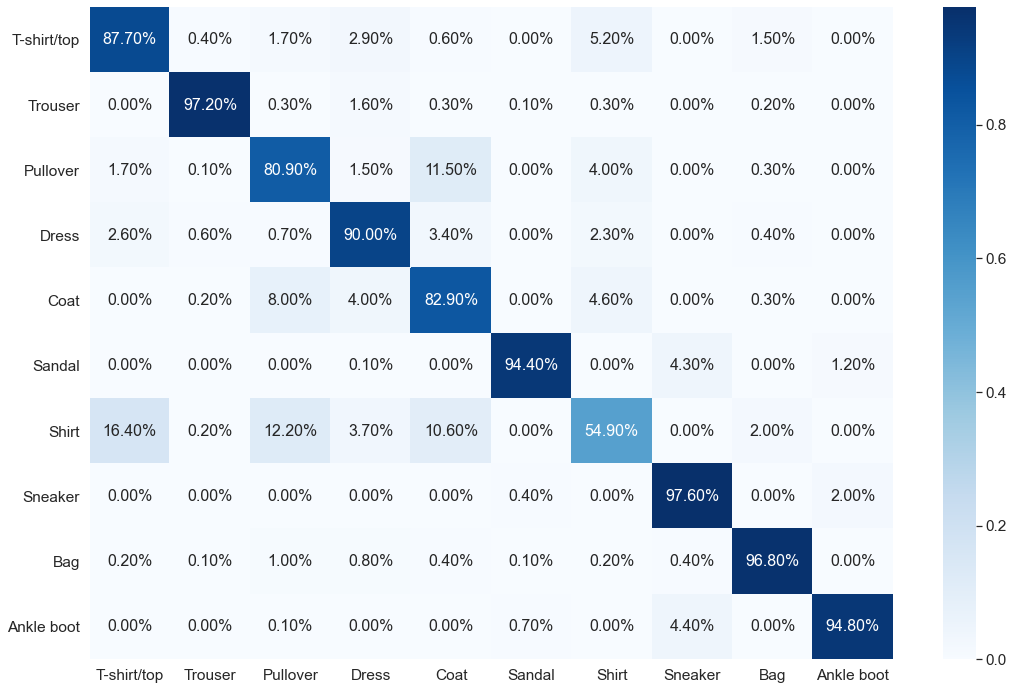

In [124]:
import seaborn as sn
import pandas as pd

# confusion matrix
cf_matrix = metrics.confusion_matrix(test_label, predictions)
print(cf_matrix)

# in percentages (tend to confuse shirt with T-shirt, pullover and coat)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in class_name],
                  columns = [i for i in class_name])
plt.figure(figsize = (18,12))
sn.set(font_scale=1.4)
sn.heatmap(df_cm/np.sum(cf_matrix,axis = 1), annot=True, annot_kws={"size": 16}, fmt='.2%', cmap='Blues')

## 3. Deploy in real world. (20 marks)

Take 3 photos that belongs to the 10 classes (e.g. clothes, shoes) in your real life. Use Python or any other software (Photoshop, Gimp etc) to convert the photos into grayscale, negate the intensities so that background becomes black or dark, crop the region of interest and reshape into the size of 28x28. You do not need to show the pre-processing step in this coursework.

### 3.1 Load and visualise your own images. (5 marks)

(3, 28, 28)


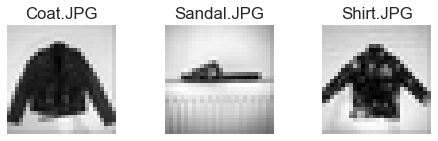

In [125]:
from PIL import Image
from matplotlib import image
import scipy.signal
images = ['Coat.JPG','Sandal.JPG','Shirt.JPG']
      
axes=[]
fig=plt.figure()
fig.set_size_inches(8, 2)
i = 0

data = []
data1 = []
for img in images:
    axes.append(fig.add_subplot(1, 3, i+1) )
    subplot_title=(img)
    axes[-1].set_title(subplot_title)
    axes[-1].axis('off')
    image = Image.open(img)
    imgd = np.asarray(image)
    data.append(imgd)
    plt.imshow(imgd,cmap=plt.cm.binary)
    i += 1

mytest = np.stack((data[0], data[1], data[2]))
print(mytest.shape)
    
plt.show()

### 3.2 Test your network on the real images and display the classification results. (5 marks)

In [126]:
# Convert to tensor
x_test = np.expand_dims(mytest, axis=1)
x_tensor = torch.from_numpy(x_test).float()

predictions = model.predict(x_tensor)
mylabel = [4,5,6]
print('Accuracy', metrics.accuracy_score(mylabel, predictions))
for i in range(len(mylabel)):
    print('Truth: ', class_name[mylabel[i]], ' Prediction: ', class_name[predictions[i]])

Accuracy 0.0
Truth:  Coat  Prediction:  Bag
Truth:  Sandal  Prediction:  T-shirt/top
Truth:  Shirt  Prediction:  Pullover


### 3.3 Comment on the classification results. (10 marks)

Does the model work? Is there anyway to improve the real life performance of the model?

The model did not really work in real life, probably due to real pictures being more noisy.
The model requires a high standard of pre-processing (position of the object and quality of the image after 
resizing to 28 x 28), and the photos I took had some shadows of me holding the camera, which may confuse the model.
Szegedy et al(2013) found that even altering a few pixels in the picture can lead to wrong classifications

It is also within expectation that the model will confuse shirt with pullover, however, it's unknown why the model
classified sandal as T-shirt (sandal was on top of a radiator?) and coat as bag.

Clothing objects in real life can also be more unique than those in the dataset, for example, the sandal in this
test image does not have any straps, which were present for sandals in the training dataset and the shirt has more patterns on it.

To improve the real life performance, maybe we can apply more advanced photo shooting and preprocessing to the real life image to match the training images.

We can also  make the neural network deeper with more layers, parameters and test different architectures on 
classifying more realistic images with the least possible amount of preprocessing(e.g. shoes facing different directions).

Another method is to collect more data, so the model will "learn the latest trends" in fashion objects.

Szegedy, C. et al. Preprint at https://arxiv.org/abs/1312.6199v1 (2013).

## 4. Survey: How long does it take you to complete the coursework?

In [ ]:
14 hours